# COVID-19 Active Cases County-level Map for U.S.

A notebook that produces a choropleth map of US Counties showing the active cases of COVID-19 per 100k residents.

David A. West
westd@us.ibm.com

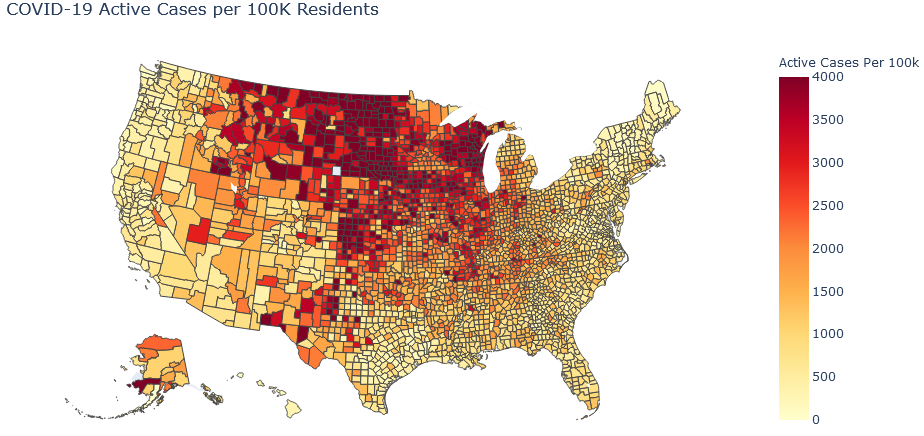

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import itertools

import numpy as np

from datetime import datetime
from datetime import date
from datetime import timedelta
now = (str(datetime.now()))
nowdate = now[0:10] 
print(nowdate)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 100em; }</style>"))


import matplotlib.ticker
class MyLocator(matplotlib.ticker.AutoMinorLocator):
    def __init__(self, n=14):
        super().__init__(n=n)
matplotlib.ticker.AutoMinorLocator = MyLocator       
myname = "David A. West | State Level Epidemic Charts-NYT Data.ipynb"
imgpath = "G:\\my demos\\jupyter\\COVID19\\images\\"

## Read NY Times Data

    Some of the data gathered by the NYT is done at the city level rather than the county level.  As a result, the 
    population data does not properly match.  As a result, I am merging Kansas City with Jackson County Missouri
    and Joplin, Missouri with Jasper County.  This will enable any subsequent state-level aggregations to be 
    handled properly and the graphics will be correctly encoded.  Also, the county names do not match the names in 
    my US Census Bureau population data, so I am standardizing the names by eliminating the words "county", "city",
    'borough", etc.  The end result is that all records except those where county = Unknown will match.

In [ ]:
src1 = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'
nyt = pd.read_csv(src1,error_bad_lines=False )
nyt = nyt.drop(['fips'],axis=1)
nyt.loc[((nyt.state == 'Missouri')&(nyt.county =="Kansas City")),'county']='Jackson'
nyt.loc[((nyt.state == 'Missouri')&(nyt.county =="Joplin")),'county']='Jasper'
nyt['county'] = nyt['county'].str.replace(" County" , "").str.replace(" City and Borough","").str.replace(" Borough" , "").str.replace(" Census Area" , "").str.replace(" Municipality", "").str.replace(' Parish', '').str.replace('.','')
nyt = nyt.groupby(['date','county','state'])['cases', 'deaths'].sum().reset_index()


## Differencing 
    Calculating the daily change to the case count and the death count within each county.  
    This is done by looping through each state and each county within the state then appending the
    resulting county-level data frame to a master data frame.  I dropped US territories and Ships 
    from the list

In [ ]:
masterdf = pd.DataFrame()
states = nyt['state'].unique()
states = np.delete(states, np.where(states == "American Samoa"))
states = np.delete(states, np.where(states == 'Diamond Princess'))
states = np.delete(states, np.where(states == 'Grand Princess'))
states = np.delete(states, np.where(states == 'Guam'))
states = np.delete(states, np.where(states == 'Northern Mariana Islands'))
states = np.delete(states, np.where(states == 'Puerto Rico'))
states = np.delete(states, np.where(states == 'Virgin Islands'))
 
for state in states:
    cnty = nyt[nyt['state']==state].copy()
    counties = cnty['county'].unique()


    
    for county in counties:
        cnty2 = cnty[cnty['county']==county].copy()
        cnty2['cases_increase'] = cnty2['cases'].diff(periods=1).fillna(0)
        cnty2['deaths_increase'] = cnty2['deaths'].diff(periods=1).fillna(0)
        masterdf = masterdf.append(cnty2)
                                                
masterdf.tail()


## Population Data
    The population dataset was created from a download of the 2019 estimated population from
    the US Census Bureau.  I also added the FIPS code to the county as this is used by the
    mapping section to plot the data.

In [ ]:
popin2 = "https://github.com/DavidAWest/COVID_data/raw/master/popmastercounty.csv"
cpop2 = pd.read_csv(popin2, dtype=str)
cpop2['POP_2019'] = cpop2['POP_2019'].fillna(0).astype('int64')
 

## Combine the data
    Merge the master county-level data with its corresponding population record.
    This is done as a left outer join.
    Any non-matches are copied to the misspop data frame and a list of the counties
    missing population data is provided.
    Note that the NYT groups all 5 boroughs of NYC into a single entity.  In the population data,
    I have zeroed out the populations of each borough except New York County (Manhattan) and 
    summed the populations of all five into that single county.

In [ ]:
masterdf = masterdf.merge(cpop2, on=['state','county'], how='left')
# Non-matches
misspop = masterdf[masterdf['POP_2019'].isnull()]
miscnty = misspop.county.unique()

## Population adjustment
    Using a per-capita metric is the only proper way to compare geographic locations.
    In this case, all calculations are based on 100,000 residents. 
    I am calculating the daily case increase, daily death increase, cumulative cases and 
    cumulative deaths per 100,000 residents.

In [ ]:
masterdf['cpcap'] = 100000 *masterdf['cases_increase'] / masterdf['POP_2019']
masterdf['dpcap'] = 100000 *masterdf['deaths_increase'] / masterdf['POP_2019']
masterdf['cpcapcum'] = 100000 *masterdf['cases'] / masterdf['POP_2019']
masterdf['dpcapcum'] = 100000 *masterdf['deaths'] / masterdf['POP_2019']

## Moving Averages
    The data have considerable variation day-to-day and many locations show evidence of a regular 
    reporting cycle that is not related to the spread of the virus.  To eliminate such effects, a
    seven-day moving average for each metric is useful.  To do this, we break out the counties (again)
    and loop through each one.  In addition, an estimate of the number of patients who have recovered
    is produced by looking back 42 days and taking the cumulative cases and removing those who died in 
    the interim.  This is a rough estimate that assumes that within 6 weeks of being diagnosed, a 
    patient will have recovered or died.  There are known exceptions to this and most recover more
    quickly.  
    
    This process is the slowest in this notebook and I should look to combine it with the prior breakout
    of counties to test to see if this would be faster.

In [ ]:
recperiod = 42
statelst = masterdf.state.unique()

cntymstr = pd.DataFrame()

for st in statelst:
    
    tmp = masterdf[masterdf['state']== st].copy()
    cntylist = tmp.county.unique()
    for cty in cntylist:
        tmp2 = tmp[tmp['county']== cty].copy()
        
        tmp2['7daycpcap'] = tmp2['cpcap'].rolling(window=7).mean()
        tmp2['7daydpcap'] = tmp2['dpcap'].rolling(window=7).mean()
        
        tmp2['rec1'] = tmp2['cases'].shift(periods=recperiod, fill_value=0) #- sd2['Deaths']
        tmp2['RecEst2'] = tmp2['rec1'] - tmp2['deaths']
        tmp2['dummy'] = 0
        tmp2['RecEst'] = tmp2[["RecEst2", "dummy"]].max(axis=1)
        tmp2['ActiveEst'] = tmp2['cases'] - (tmp2['deaths'] + tmp2['RecEst'])
        
        cntymstr = cntymstr.append(tmp2)

        

## Final processing
    Only records that have a county match should be plotted...without a match, they won't plot.
    Also calculating the per capita active cases based on the prior Active estimate.
    The conversion of the fips code is no longer necessary, but it remains...  I changed the 
    initial read so that it reads FIPS as a string and retains the leading zeros.
    
    Lastly, we only need the most recent record for each county for the plot.
    

In [ ]:
cntymstr = cntymstr[cntymstr['POP_2019']>0]
cntymstr['apcap'] = 100000*cntymstr['ActiveEst'] / cntymstr['POP_2019']
cntymstr['fipsc'] = cntymstr['fips'].fillna(0).astype('int').astype('str').str.zfill(5)
cntycurr = cntymstr[cntymstr['date']==cntymstr['date'].max()]

## Shape files 
    Get the shapes and fips codes for each county.

In [ ]:
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

counties["features"][0]

## Plot it

In [ ]:
import plotly.express as px
fig = px.choropleth(cntycurr, geojson=counties, locations='fipsc', color='apcap',
                           color_continuous_scale="YlOrRd",
                           range_color=(0, 4000),
                           scope="usa",
                           hover_name='county',
                           labels={'apcap':'Active Cases Per 100k'}
                          )
#fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    title_text = 'COVID-19 Active Cases per 100K Residents',
    geo_scope='usa', # limite map scope to USA
)
fig.show()